In [1]:
import time
from IPython.display import clear_output
import numpy    as np
import pandas   as pd
import seaborn  as sb
import matplotlib.pyplot as plt
import sklearn  as skl

from sklearn import pipeline      # Pipeline
from sklearn import preprocessing # OrdinalEncoder, LabelEncoder
from sklearn import impute
from sklearn import compose
from sklearn import model_selection # train_test_split
from sklearn import metrics         # accuracy_score, balanced_accuracy_score, plot_confusion_matrix
from sklearn import set_config
from sklearn.impute import KNNImputer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer

set_config(display='diagram') # Useful for display the pipeline

print("Pandas  ", pd.__version__)
print("Sklearn ", skl.__version__) # Try to use 0.24

Pandas   1.2.4
Sklearn  0.24.2


### Importing Dataset

In [2]:
CLOUD = False

if CLOUD:
    import os
    os.environ['KAGGLE_USERNAME'] = "umutakta"
    os.environ['KAGGLE_KEY']      = "a471e5474add8d57cadac3cc5ff2b1d6"  
    !pip install --upgrade kaggle
    !kaggle competitions download -c competitive-data-science-predict-future-sales
    DATA_PATH = "/work/Strive_School/Feature_Engineering_(Module_4)/Day_6_Feature_Selection/competitive-data-science-predict-future-sales/"

else:
    DATA_PATH = "/work/competitive-data-science-predict-future-sales/"

DATA_PATH

'/work/competitive-data-science-predict-future-sales/'

**Creating Data Frame**

In [3]:
df_item_categ=pd.read_csv(DATA_PATH+"item_categories.csv")
df_items=pd.read_csv(DATA_PATH+"items.csv")
df=pd.read_csv(DATA_PATH+"sales_train.csv")
df_sample=pd.read_csv(DATA_PATH+"sample_submission.csv")
df_shops=pd.read_csv(DATA_PATH+"shops.csv")
df_test=pd.read_csv(DATA_PATH+"test.csv")

In [4]:
df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


Turning date column to **date type**

In [5]:
from datetime import datetime

df["date"]=df['date'].apply(lambda x:datetime.strptime(x, '%d.%m.%Y'))


### Deleting Outliers

**Item Count Day**

In [6]:
df=df.drop(df.loc[df.item_cnt_day<0].index.tolist())

<AxesSubplot:xlabel='item_cnt_day'>

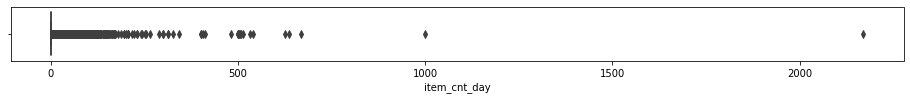

In [7]:
plt.figure(figsize=(16,1))
sb.boxplot(x=df.item_cnt_day)

**Item Price**

In [8]:
for i in range(5):
    df=df.drop(df.index[df.loc[df.item_price==df.item_price.max()].index[0]])

<AxesSubplot:xlabel='item_price'>

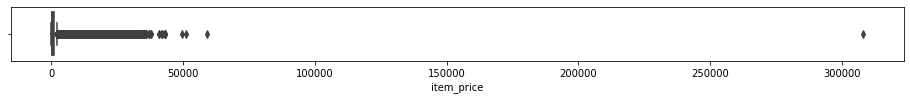

In [9]:
plt.figure(figsize=(16,1))
sb.boxplot(x=df.item_price)

#### Creating new data frame for only 2013,2014,2015

In [10]:
df_2013=df[(df.date<"01-01-2014") & ("31-12-2012"<df.date)]
df_2014=df[(df.date<"01-01-2015") & ("31-12-2013"<df.date)]
df_2015=df[(df.date<"01-01-2016") & ("31-12-2014"<df.date)]

** Grouping monthly sales **

In [11]:
df_2013['total_income_13']=df_2013.item_price*df_2013.item_cnt_day
df13_total=df_2013.groupby(['date_block_num']).sum()

df_2014['total_income_14']=df_2014.item_price*df_2014.item_cnt_day
df14_total=df_2014.groupby(['date_block_num']).sum()

df_2015['total_income_15']=df_2015.item_price*df_2015.item_cnt_day
df15_total=df_2015.groupby(['date_block_num']).sum()

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

** Plot by total income for 2013 and 2014**

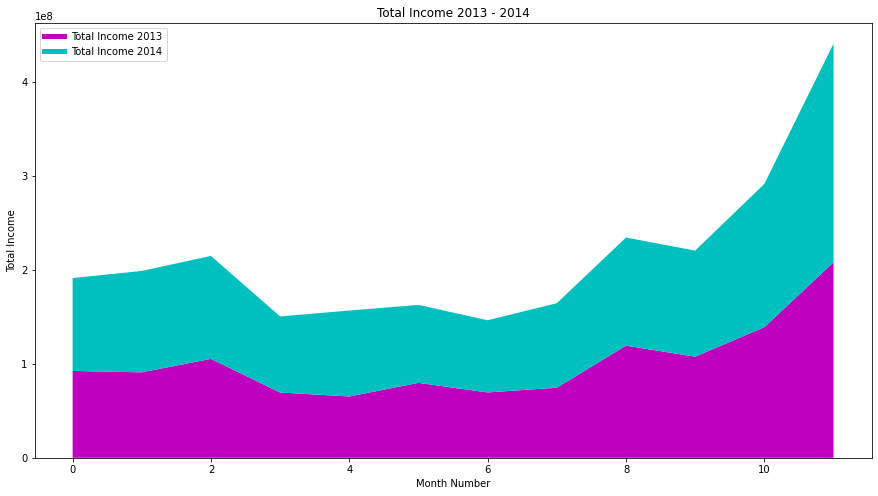

In [12]:
plt.subplots(figsize=(15,8))

plt.plot([],[],color='m', label='Total Income 2013', linewidth=5)
plt.plot([],[],color='c', label='Total Income 2014', linewidth=5)

plt.stackplot(df13_total.index, df13_total.total_income_13, df14_total.total_income_14,colors=['m','c'])

plt.xlabel('Month Number')
plt.ylabel('Total Income')
plt.title('Total Income 2013 - 2014')
plt.legend(loc='upper left')
plt.show()

** Total Income Plotting Until October in 2013,2014 and 2015 **

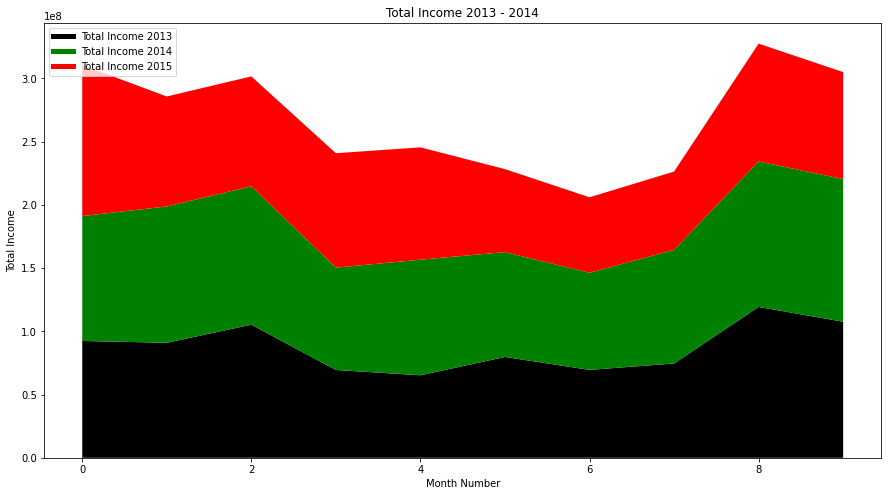

In [51]:
plt.subplots(figsize=(15,8))

plt.plot([],[],color='k', label='Total Income 2013', linewidth=5)
plt.plot([],[],color='g', label='Total Income 2014', linewidth=5)
plt.plot([],[],color='r', label='Total Income 2015', linewidth=5)

plt.stackplot(df13_total.index[:10], df13_total.loc[:9].total_income_13, 
    df14_total.loc[:21].total_income_14,df15_total.total_income_15,colors=['k','g',"r"])

plt.xlabel('Month Number')
plt.ylabel('Total Income')
plt.title('Total Income 2013 - 2014')
plt.legend(loc='upper left')
plt.show()

#### Interesting with shop id

Finding different shops between years

In [65]:
set_difference_13_14 = set(df_2013.shop_id.unique()) - set(df_2014.shop_id.unique())
list_difference_13_14 = list(set_difference_13_14)
list_difference_13_14

[0, 1, 32, 8, 23]

In [64]:
set_difference_14_15 = set(df_2014.shop_id.unique()) - set(df_2015.shop_id.unique())
list_difference_14_15 = list(set_difference_14_15)
list_difference

[13]

In [53]:
df_2013.groupby(["shop_id"]).sum()

,date_block_num,item_id,item_price,item_cnt_day,total_income_13
shop_id,,,,,
0,5064,104811661,5.553869e+06,11705.0,6.637370e+06
1,2984,60950373,2.926161e+06,6311.0,3.238207e+06
2,50270,72717743,1.032134e+07,9989.0,1.318296e+07
3,53320,84190900,7.331793e+06,10242.0,8.699230e+06
4,90079,148853533,1.330332e+07,19054.0,1.592225e+07
5,85622,133165128,9.181055e+06,14717.0,1.082050e+07
6,211678,370602264,2.779599e+07,46702.0,3.800108e+07
7,138191,236498690,1.922418e+07,28218.0,2.387673e+07
8,2942,34216674,2.223329e+06,3602.0,2.353301e+06


In [54]:
df_2014.groupby(["shop_id"]).sum()

,date_block_num,item_id,item_price,item_cnt_day,total_income_14
shop_id,,,,,
2,179035,83280536,1.493348e+07,12247.0,1.909542e+07
3,170929,86364857,1.079431e+07,11039.0,1.250937e+07
4,238779,123118075,1.402430e+07,15909.0,1.590347e+07
5,262842,148542142,1.449206e+07,17041.0,1.686703e+07
6,505507,287568449,2.904261e+07,35496.0,3.798799e+07
7,367622,199780518,2.232456e+07,24530.0,2.656249e+07
9,29757,18231529,1.839812e+06,6155.0,6.615741e+06
10,135064,70504092,6.879313e+06,8859.0,7.944205e+06
12,222460,126081526,1.914270e+07,26379.0,4.329083e+07


In [55]:
df_2015.groupby(["shop_id"]).sum()

,date_block_num,item_id,item_price,item_cnt_day,total_income_15
shop_id,,,,,
2,203231,65646918,9.704364e+06,8470.0,1.193511e+07
3,180380,58330706,8.127820e+06,7194.0,9.152854e+06
4,224204,78807345,7.833780e+06,9106.0,8.889769e+06
5,280722,103824865,9.454980e+06,11089.0,1.060567e+07
6,441693,160598359,1.731887e+07,18554.0,2.248109e+07
7,355238,126371073,1.439615e+07,14411.0,1.665116e+07
9,27819,13347618,1.247866e+06,3188.0,3.921876e+06
10,113599,39127973,3.417937e+06,4532.0,4.010307e+06
11,12475,4839666,4.798425e+05,572.0,5.216551e+05


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=796ba814-f632-4502-b0d7-7e2f8f9e546d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>